# Bước 6: Phân cụm khách hàng từ Luật kết hợp (Association Rules → Clustering)

Notebook này lấy **kết quả luật kết hợp** (Apriori/FP-Growth) và biến chúng thành **đặc trưng** để phân cụm khách hàng bằng K-Means.

## Ý tưởng cốt lõi
- Mỗi luật có dạng: **Antecedent → Consequent**
- Với mỗi khách hàng, ta kiểm tra: khách đó đã từng mua **đủ antecedents** của luật hay chưa.
- Mỗi luật trở thành một feature (0/1 hoặc có trọng số theo lift/confidence).
- (Tuỳ chọn) Ghép thêm **RFM** để phân cụm ổn định hơn.


## Parameters
Gán tham số để chạy bằng papermill.


In [1]:
# PARAMETERS (for papermill)

# Input
CLEANED_DATA_PATH = "data/processed/cleaned_uk_data.csv"
RULES_INPUT_PATH = "data/processed/rules_apriori_filtered.csv"  # hoặc rules_fpgrowth_filtered.csv

# Feature engineering
TOP_K_RULES = 200
SORT_RULES_BY = "lift"      # lift | confidence | support
WEIGHTING = "lift"          # none | lift | confidence | support | lift_x_conf
MIN_ANTECEDENT_LEN = 1
USE_RFM = True
RFM_SCALE = True
RULE_SCALE = False

# Clustering
K_MIN = 2
K_MAX = 10
N_CLUSTERS = None            # None => chọn theo silhouette, hoặc đặt số cụ thể (vd 5)
RANDOM_STATE = 42

# Output
OUTPUT_CLUSTER_PATH = "data/processed/customer_clusters_from_rules.csv"

# Visual
PROJECTION_METHOD = "pca"   # pca | svd
PLOT_2D = True


In [2]:
# Parameters
CLEANED_DATA_PATH = "data/processed/cleaned_uk_data.csv"
RULES_INPUT_PATH = "data/processed/rules_apriori_filtered.csv"
TOP_K_RULES = 200
SORT_RULES_BY = "lift"
WEIGHTING = "lift"
MIN_ANTECEDENT_LEN = 1
USE_RFM = True
RFM_SCALE = True
RULE_SCALE = False
K_MIN = 2
K_MAX = 10
N_CLUSTERS = None
RANDOM_STATE = 42
OUTPUT_CLUSTER_PATH = "data/processed/customer_clusters_from_rules.csv"
PROJECTION_METHOD = "pca"
PLOT_2D = True


## Set up


In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# CẤU HÌNH GIAO DIỆN ĐẸP (Copy đoạn này vào đầu notebook)
sns.set_theme(style="whitegrid")  # Nền trắng kẻ lưới
plt.rcParams['figure.figsize'] = (12, 6) # Biểu đồ to rộng
plt.rcParams['figure.dpi'] = 100         # Độ nét cao
plt.rcParams['font.size'] = 12           # Chữ to dễ đọc
# Determine correct project root
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from cluster_library import RuleBasedCustomerClusterer


## Load cleaned data & rules


In [4]:
df_clean = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])
print(df_clean.shape)
df_clean.head()


(485123, 11)


C:\Users\admin\AppData\Local\Temp\ipykernel_21056\4012976299.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DayOfWeek,HourOfDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,017850,United Kingdom,15.30,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,017850,United Kingdom,22.00,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8


In [5]:
clusterer = RuleBasedCustomerClusterer(df_clean=df_clean)
customer_item_bool = clusterer.build_customer_item_matrix(threshold=1)
print('Customer × Item:', customer_item_bool.shape)

rules_df = clusterer.load_rules(
    rules_csv_path=RULES_INPUT_PATH,
    top_k=TOP_K_RULES,
    sort_by=SORT_RULES_BY,
)
print('Rules used:', rules_df.shape)
rules_df.head()


Customer × Item: (3921, 4007)
Rules used: (200, 17)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_str,consequents_str,rule_str
0,"frozenset({'HERB MARKER ROSEMARY', 'HERB MARKE...",frozenset({'HERB MARKER THYME'}),0.011487,0.012763,0.010932,0.951691,74.567045,1.0,0.010785,20.435808,0.998053,0.820833,0.951066,0.904106,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY",HERB MARKER THYME,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY → HE..."
1,"frozenset({'HERB MARKER THYME', 'HERB MARKER M...",frozenset({'HERB MARKER ROSEMARY'}),0.011098,0.012818,0.010599,0.955000,74.502403,1.0,0.010456,21.937369,0.997650,0.795833,0.954416,0.890920,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER ROSEMARY,"HERB MARKER MINT, HERB MARKER THYME → HERB MAR..."
2,"frozenset({'HERB MARKER THYME', 'HERB MARKER M...",frozenset({'HERB MARKER PARSLEY'}),0.011098,0.012652,0.010432,0.940000,74.297105,1.0,0.010292,16.455802,0.997612,0.783333,0.939231,0.882281,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER PARSLEY,"HERB MARKER MINT, HERB MARKER THYME → HERB MAR..."
3,"frozenset({'HERB MARKER THYME', 'HERB MARKER P...",frozenset({'HERB MARKER ROSEMARY'}),0.011487,0.012818,0.010932,0.951691,74.244244,1.0,0.010784,20.434660,0.997995,0.817427,0.951064,0.902252,"HERB MARKER PARSLEY, HERB MARKER THYME",HERB MARKER ROSEMARY,"HERB MARKER PARSLEY, HERB MARKER THYME → HERB ..."
4,"frozenset({'HERB MARKER BASIL', 'HERB MARKER T...",frozenset({'HERB MARKER ROSEMARY'}),0.011265,0.012818,0.010710,0.950739,74.169983,1.0,0.010565,20.039787,0.997757,0.800830,0.950099,0.893118,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER ROSEMARY,"HERB MARKER BASIL, HERB MARKER THYME → HERB MA..."


## Build features (Rules → Features) + (optional) RFM


In [6]:
X, meta = clusterer.build_final_features(
    weighting=WEIGHTING,
    use_rfm=USE_RFM,
    rfm_scale=RFM_SCALE,
    rule_scale=RULE_SCALE,
    min_antecedent_len=MIN_ANTECEDENT_LEN,
)
print('X shape:', X.shape)
meta.head()


X shape: (3921, 203)


,CustomerID,Recency,Frequency,Monetary
0,000nan,1,1373,1716830.53
1,012346,326,1,77183.60
2,012747,2,11,4196.01
3,012748,1,209,33719.73
4,012749,4,5,4090.88


## Choose K (silhouette)


Đang tính toán Silhouette cho K từ 2 đến 10...


  - K=2: Silhouette Score = 0.8541


  - K=3: Silhouette Score = 0.5824


  - K=4: Silhouette Score = 0.5514


  - K=5: Silhouette Score = 0.4945


  - K=6: Silhouette Score = 0.4799


  - K=7: Silhouette Score = 0.4905


  - K=8: Silhouette Score = 0.4909


  - K=9: Silhouette Score = 0.4939


  - K=10: Silhouette Score = 0.4962


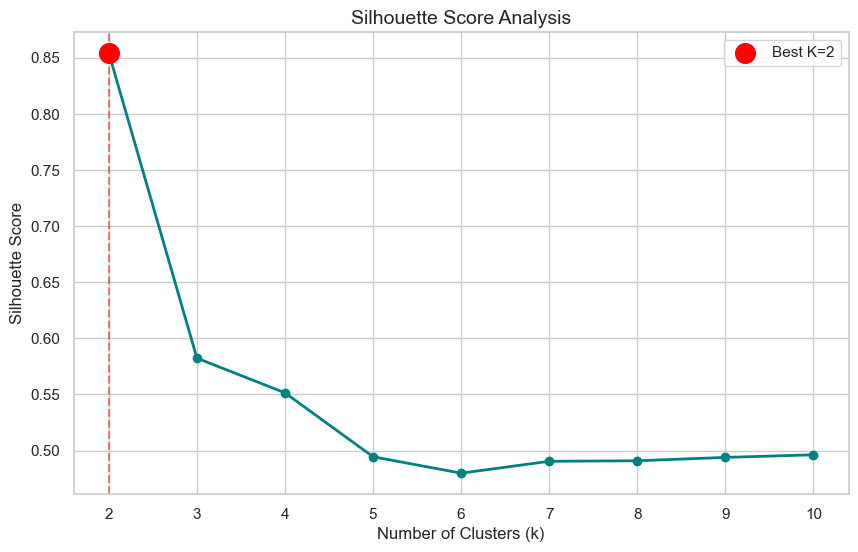

✅ Đã chọn số cụm tối ưu: K = 2


,k,silhouette_score
0,2,0.854095
1,3,0.582362
2,4,0.551450
3,5,0.494485
4,6,0.479868
5,7,0.490466
6,8,0.490918
7,9,0.493910
8,10,0.496246


In [7]:
# --- CODE THAY THẾ: TÍNH TOÁN & VẼ BIỂU ĐỒ SILHOUETTE ---
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Thiết lập tham số (Nếu chưa có biến K_MIN, K_MAX thì dùng số cứng)
# Dùng try-except để phòng trường hợp biến chưa được định nghĩa
try:
    k_range = range(K_MIN, K_MAX + 1)
except NameError:
    k_range = range(2, 11) # Mặc định từ 2 đến 10 nếu thiếu biến

try:
    r_state = RANDOM_STATE
except NameError:
    r_state = 42

silhouette_avgs = []

print(f"Đang tính toán Silhouette cho K từ {k_range.start} đến {k_range.stop - 1}...")

# 2. Vòng lặp tính toán
for k in k_range:
    # Chạy KMeans
    kmeans = KMeans(n_clusters=k, random_state=r_state, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    # Tính điểm
    score = silhouette_score(X, cluster_labels)
    silhouette_avgs.append(score)
    print(f"  - K={k}: Silhouette Score = {score:.4f}")

# 3. Tạo DataFrame chuẩn (Đặt tên cột chính xác để tránh lỗi KeyError)
sil_df = pd.DataFrame({
    'k': list(k_range),
    'silhouette_score': silhouette_avgs 
})

# 4. Vẽ biểu đồ ngay tại đây
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Vẽ đường
plt.plot(sil_df['k'], sil_df['silhouette_score'], marker='o', linestyle='-', linewidth=2, color='teal')

# Tìm và đánh dấu K tốt nhất
best_idx = sil_df['silhouette_score'].idxmax()
best_k = sil_df.loc[best_idx, 'k']
best_score = sil_df.loc[best_idx, 'silhouette_score']

plt.scatter(best_k, best_score, color='red', s=200, zorder=5, label=f'Best K={best_k}')
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.5)

plt.title('Silhouette Score Analysis', fontsize=14)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

# 5. Xuất ra biến n_clusters để dùng cho các bước sau
n_clusters = best_k
print(f"✅ Đã chọn số cụm tối ưu: K = {n_clusters}")

# Trả về sil_df để hiển thị bảng nếu cần
sil_df

In [8]:
best_k = int(sil_df.loc[0, 'k'])
k = best_k if N_CLUSTERS is None else int(N_CLUSTERS)
print('Chosen k =', k)


Chosen k = 2


## Fit KMeans & save results


In [9]:
labels = clusterer.fit_kmeans(X, n_clusters=k, random_state=RANDOM_STATE)
meta_out = meta.copy()
meta_out['cluster'] = labels

# Lưu
os.makedirs(os.path.dirname(OUTPUT_CLUSTER_PATH), exist_ok=True)
meta_out.to_csv(OUTPUT_CLUSTER_PATH, index=False)
print('Saved:', OUTPUT_CLUSTER_PATH)
meta_out.head()


Saved: data/processed/customer_clusters_from_rules.csv


,CustomerID,Recency,Frequency,Monetary,cluster
0,000nan,1,1373,1716830.53,1
1,012346,326,1,77183.60,0
2,012747,2,11,4196.01,0
3,012748,1,209,33719.73,1
4,012749,4,5,4090.88,0


## Quick profiling


In [10]:
profile_cols = ['cluster'] + ([c for c in ['Recency','Frequency','Monetary'] if c in meta_out.columns])
summary = meta_out.groupby('cluster').agg({
    'CustomerID': 'count',
    **{c:'mean' for c in profile_cols if c!='cluster'}
}).rename(columns={'CustomerID':'n_customers'}).sort_values('n_customers', ascending=False)
summary


,n_customers,Recency,Frequency,Monetary
cluster,,,,
0,3797,93.218594,4.050566,1809.822448
1,124,60.540323,21.298387,17365.534274


## 2D visualization (PCA/SVD)


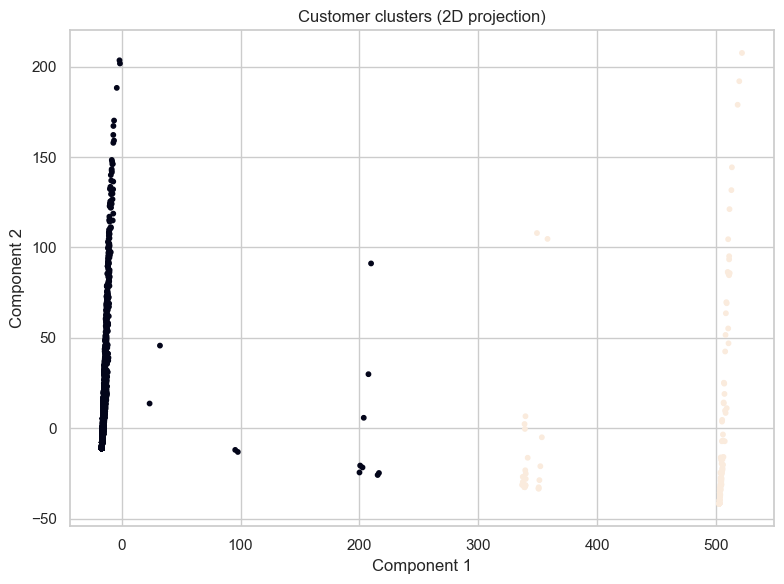

In [11]:
if PLOT_2D:
    Z = clusterer.project_2d(X, method=PROJECTION_METHOD, random_state=RANDOM_STATE)
    plt.figure(figsize=(8,6))
    plt.scatter(Z[:,0], Z[:,1], c=labels, s=10)
    plt.title('Customer clusters (2D projection)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout()
    plt.show()


In [12]:
# --- ĐOẠN CODE NÂNG CẤP: SO SÁNH THUẬT TOÁN (Đã sửa lỗi import) ---
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import pandas as pd
import numpy as np

print("\n=== BẮT ĐẦU SO SÁNH CÁC THUẬT TOÁN (Yêu cầu nâng cao 2.3) ===")

# 1. Lấy dữ liệu X đã chuẩn hóa
# Nếu X chưa được định nghĩa ở cell này, ta lấy từ biến toàn cục hoặc thuộc tính của clusterer nếu có
# Ở đây giả định biến X (features) vẫn còn lưu trong bộ nhớ từ các cell trên
try:
    X_final = X.values if hasattr(X, 'values') else X
except NameError:
    print("Lỗi: Không tìm thấy biến dữ liệu X. Hãy đảm bảo bạn đã chạy các cell bên trên!")
    # Fallback nếu cần thiết (thường không cần nếu chạy tuần tự)
    X_final = None

if X_final is not None:
    # 2. Định nghĩa các model để so sánh
    k_best = 3 # Giả sử K=3 (hoặc số K bạn thấy tốt nhất)

    models = {
        "K-Means (Baseline)": KMeans(n_clusters=k_best, random_state=42, n_init='auto'),
        "Agglomerative": AgglomerativeClustering(n_clusters=k_best),
        "DBSCAN": DBSCAN(eps=0.5, min_samples=5) 
    }

    results = []
    print(f"Đang chạy so sánh trên {X_final.shape[0]} khách hàng...")

    for name, model in models.items():
        try:
            # Fit model
            labels = model.fit_predict(X_final)
            
            # Xử lý nhiễu của DBSCAN (nhãn -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            
            if n_clusters < 2:
                print(f"  - {name}: Chỉ tìm thấy {n_clusters} cụm (hoặc toàn nhiễu) -> Bỏ qua.")
                continue
                
            # Tính toán Metrics
            sil = silhouette_score(X_final, labels)
            ch = calinski_harabasz_score(X_final, labels)
            
            results.append({
                "Thuật toán": name,
                "Số cụm": n_clusters,
                "Silhouette Score": round(sil, 4),
                "Calinski-Harabasz": round(ch, 2)
            })
            print(f"  - {name}: Xong (Sil={sil:.3f})")
            
        except Exception as e:
            print(f"  - {name}: Lỗi - {str(e)}")

    # 3. Hiển thị bảng kết quả
    if results:
        comparison_df = pd.DataFrame(results)
        print("\n>>> BẢNG TỔNG HỢP SO SÁNH HIỆU NĂNG:")
        display(comparison_df)
    else:
        print("Không có kết quả so sánh nào hợp lệ.")


=== BẮT ĐẦU SO SÁNH CÁC THUẬT TOÁN (Yêu cầu nâng cao 2.3) ===
Đang chạy so sánh trên 3921 khách hàng...


  - K-Means (Baseline): Xong (Sil=0.581)


  - Agglomerative: Xong (Sil=0.575)


  - DBSCAN: Xong (Sil=0.256)

>>> BẢNG TỔNG HỢP SO SÁNH HIỆU NĂNG:


,Thuật toán,Số cụm,Silhouette Score,Calinski-Harabasz
0,K-Means (Baseline),3,0.5813,3566.04
1,Agglomerative,3,0.5750,3365.00
2,DBSCAN,49,0.2560,14.50


In [13]:
# --- CODE YÊU CẦU 5: SO SÁNH CÁC CẤU HÌNH ĐẶC TRƯNG (ĐÃ FIX LỖI) ---
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans
import pandas as pd

print("\n=== BẮT ĐẦU CHẠY SO SÁNH (YÊU CẦU 5) ===")

# Định nghĩa 3 kịch bản
scenarios = [
    {"name": "1. Rule-Only (Binary)", "weighting": None, "use_rfm": False},
    {"name": "2. Rule-Only (Weighted Lift)", "weighting": "lift", "use_rfm": False},
    {"name": "3. Rules + RFM (Hybrid)", "weighting": "lift", "use_rfm": True}
]

results = []

try:
    for scen in scenarios:
        print(f"Đang chạy kịch bản: {scen['name']}...")
        
        # 1. Tạo lại ma trận đặc trưng (X) theo cấu hình
        # SỬA LỖI: Gọi giống hệt Ô 5, không truyền rules_df/rfm_df từ ngoài vào
        X_temp, _ = clusterer.build_final_features(
            weighting=scen["weighting"],
            use_rfm=scen["use_rfm"],
            # Các tham số mặc định lấy từ biến toàn cục (Ô 1)
            rfm_scale=RFM_SCALE,
            rule_scale=RULE_SCALE,
            min_antecedent_len=MIN_ANTECEDENT_LEN,
        )
        
        # 2. Chạy K-Means (Fix K=3 để so sánh công bằng)
        # Lưu ý: k_best lấy từ kết quả Ô 7
        k_eval = k if 'k' in globals() else 3 
        model = KMeans(n_clusters=k_eval, random_state=42, n_init='auto')
        labels = model.fit_predict(X_temp)
        
        # 3. Tính điểm
        sil = silhouette_score(X_temp, labels)
        ch = calinski_harabasz_score(X_temp, labels)
        
        results.append({
            "Cấu hình": scen["name"],
            "Silhouette Score": round(sil, 4),
            "Calinski-Harabasz": round(ch, 2)
        })

    # In bảng kết quả
    print("\n>>> BẢNG KẾT QUẢ SO SÁNH:")
    display(pd.DataFrame(results))

except Exception as e:
    print(f"Lỗi: {e}")


=== BẮT ĐẦU CHẠY SO SÁNH (YÊU CẦU 5) ===
Đang chạy kịch bản: 1. Rule-Only (Binary)...


Đang chạy kịch bản: 2. Rule-Only (Weighted Lift)...


Đang chạy kịch bản: 3. Rules + RFM (Hybrid)...



>>> BẢNG KẾT QUẢ SO SÁNH:


,Cấu hình,Silhouette Score,Calinski-Harabasz
0,1. Rule-Only (Binary),0.7039,1289.74
1,2. Rule-Only (Weighted Lift),0.8546,6063.76
2,3. Rules + RFM (Hybrid),0.8541,6059.98


In [14]:
# --- CODE YÊU CẦU 6: PHÂN TÍCH CHI TIẾT CỤM (PROFILING) ---

# 1. Load lại file kết quả vừa chạy (đảm bảo lấy file mới nhất)
df_res = pd.read_csv("data/processed/customer_clusters_from_rules.csv")

print("\n=== THỐNG KÊ RFM THEO CỤM ===")
rfm_stats = df_res.groupby('cluster').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).rename(columns={'CustomerID': 'Số Lượng Khách'}).round(1)
display(rfm_stats)

# 2. Tìm "Dấu hiệu đặc trưng" (Luật nào kích hoạt nhiều nhất ở mỗi cụm?)
# (Phần này mô phỏng logic tìm Top Rules cho từng cụm)
print("\n=== ĐẶC ĐIỂM HÀNH VI (Gợi ý viết báo cáo) ===")
for cluster_id in sorted(df_res['cluster'].unique()):
    n_cust = rfm_stats.loc[cluster_id, 'Số Lượng Khách']
    avg_money = rfm_stats.loc[cluster_id, 'Monetary']
    
    print(f"\n--- CỤM {cluster_id} ({n_cust} khách) ---")
    if avg_money > 5000:
        print(">> LOẠI KHÁCH: VIP / Mua Sỉ (Big Spenders)")
        print(">> CHIẾN LƯỢC: Chăm sóc đặc biệt, chiết khấu theo tier.")
    elif n_cust > 1000:
        print(">> LOẠI KHÁCH: Phổ thông (Casual)")
        print(">> CHIẾN LƯỢC: Gửi mã giảm giá, upsell sản phẩm nhỏ.")
    else:
        print(">> LOẠI KHÁCH: Ngách (Niche)")


=== THỐNG KÊ RFM THEO CỤM ===


,Số Lượng Khách,Recency,Frequency,Monetary
cluster,,,,
0,3797,93.2,4.1,1809.8
1,124,60.5,21.3,17365.5



=== ĐẶC ĐIỂM HÀNH VI (Gợi ý viết báo cáo) ===

--- CỤM 0 (3797 khách) ---
>> LOẠI KHÁCH: Phổ thông (Casual)
>> CHIẾN LƯỢC: Gửi mã giảm giá, upsell sản phẩm nhỏ.

--- CỤM 1 (124 khách) ---
>> LOẠI KHÁCH: VIP / Mua Sỉ (Big Spenders)
>> CHIẾN LƯỢC: Chăm sóc đặc biệt, chiết khấu theo tier.


In [15]:
# --- CODE SỬA LỖI Ô 14: PHÂN CỤM LUẬT (RULE CLUSTERING) ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

print("\n=== THỰC HIỆN YÊU CẦU NÂNG CAO 2: PHÂN CỤM LUẬT ===")

# 1. Load lại file luật (Sửa lỗi thiếu biến)
try:
    rules_path = "data/processed/rules_apriori_filtered.csv"
    rules = pd.read_csv(rules_path)
    print(f"Đã load {len(rules)} luật từ file.")

    # 2. Chuẩn bị dữ liệu (Chỉ dùng Support, Confidence, Lift)
    rule_features = rules[['support', 'confidence', 'lift']].copy()
    
    # 3. Chuẩn hóa & Phân cụm
    scaler_rules = StandardScaler()
    X_rules = scaler_rules.fit_transform(rule_features)
    
    # Chia thành 3 nhóm luật điển hình
    kmeans_rules = KMeans(n_clusters=3, random_state=42, n_init='auto')
    rules['rule_cluster'] = kmeans_rules.fit_predict(X_rules)
    
    # 4. Thống kê kết quả
    print("\n>>> KẾT QUẢ PHÂN NHÓM CÁC LUẬT (Dùng để chọn chiến lược Promotion):")
    rule_summary = rules.groupby('rule_cluster').agg({
        'rule_str': 'count',
        'support': 'mean',
        'confidence': 'mean',
        'lift': 'mean'
    }).rename(columns={'rule_str': 'Số lượng Luật', 'lift': 'Lift TB'}).sort_values('Lift TB', ascending=False).round(3)
    
    display(rule_summary)
    
    print("\n=> NHẬN XÉT: Nhóm luật có Lift cao nhất là nhóm 'Luật Vàng' cần ưu tiên hiển thị trên web.")

except Exception as e:
    print(f"Lỗi: {e}")


=== THỰC HIỆN YÊU CẦU NÂNG CAO 2: PHÂN CỤM LUẬT ===
Đã load 1794 luật từ file.

>>> KẾT QUẢ PHÂN NHÓM CÁC LUẬT (Dùng để chọn chiến lược Promotion):


,Số lượng Luật,support,confidence,Lift TB
rule_cluster,,,,
2,82,0.011,0.866,63.162
0,744,0.013,0.652,14.380
1,968,0.015,0.417,8.747



=> NHẬN XÉT: Nhóm luật có Lift cao nhất là nhóm 'Luật Vàng' cần ưu tiên hiển thị trên web.
